# 데이터 클렌징 및 가공과 데이터 시각화

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

bike_df = pd.read_csv('./자전거_수요예측/bike-sharing-demand/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [7]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns,axis=1,inplace=True)

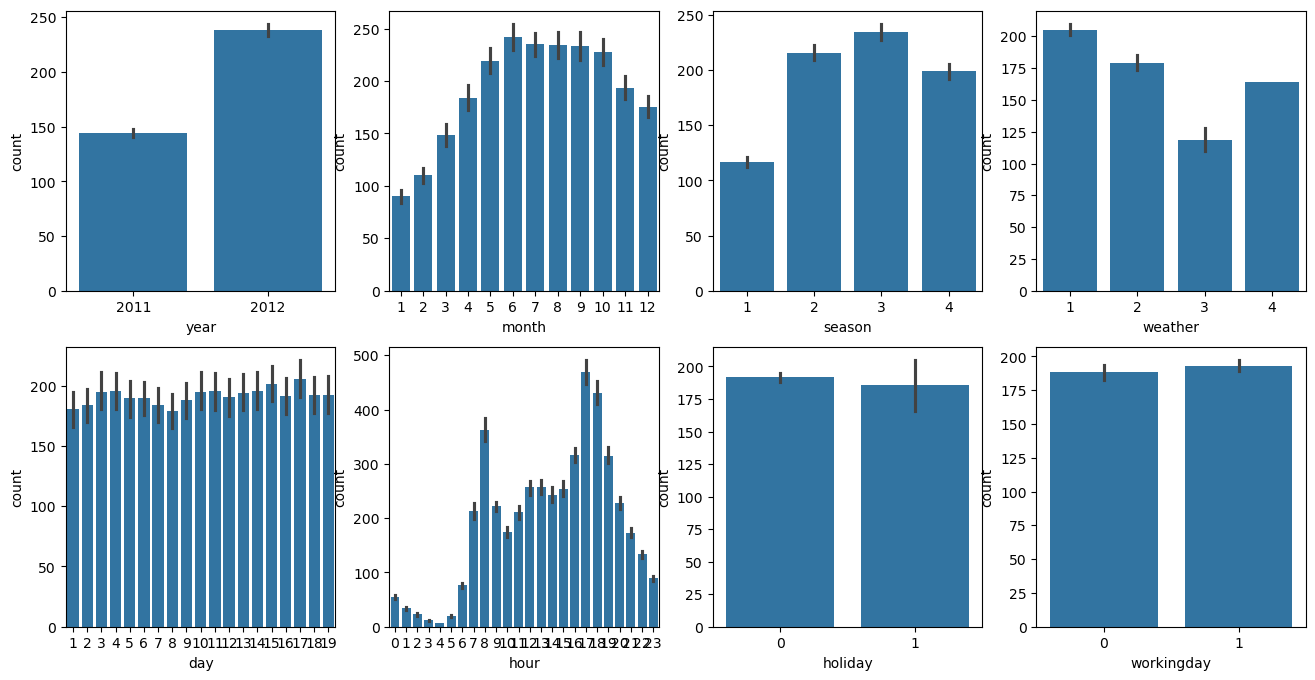

In [9]:
# 시각화
fig,axs = plt.subplots(figsize=(16,8),ncols=4,nrows=2)
cat_features = ['year','month','season','weather','day','hour','holiday','workingday']

for i, feature in enumerate(cat_features):
    row = i//4
    col = i%4
    sns.barplot(data=bike_df,x=feature,y='count',ax=axs[row][col])

In [12]:
# 사이킷런은 rmsle를 제공하지 않음
from sklearn.metrics import mean_squared_error, mean_absolute_error

#log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산 
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error)) 
    return rmsle

#사이킷런의 mean_square_error()를 이용해 RMSE 계산 
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))
# MSE, RMSE, RMSLE를 모두 계산 
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))


# 로그 변환, 피처 인코딩과 모델학습/예측/평가

In [13]:
# 기본 선형회귀 예측
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso

y_target = bike_df['count']
X_features = bike_df.drop('count',axis=1,inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_features, y_target,test_size=0.3,
                                                 random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [15]:
bike_df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [24]:
def get_top_error_data(y_test,pred,n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
    result_df =pd.DataFrame(y_test, columns=['count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['count'] - result_df['predicted_count'])
    
    #예측값과 실제 값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)


      count  predicted_count   diff
9944    890            322.0  568.0
9767    798            241.0  557.0
9921    884            327.0  557.0
9791    745            194.0  551.0
9536    856            310.0  546.0


<AxesSubplot:>

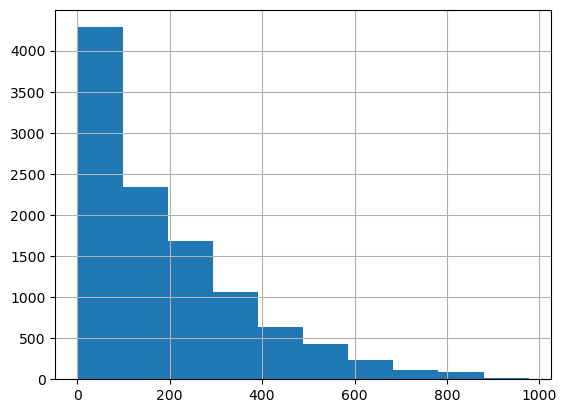

In [25]:
y_target.hist() # 판다스의 hist() 이용

<AxesSubplot:>

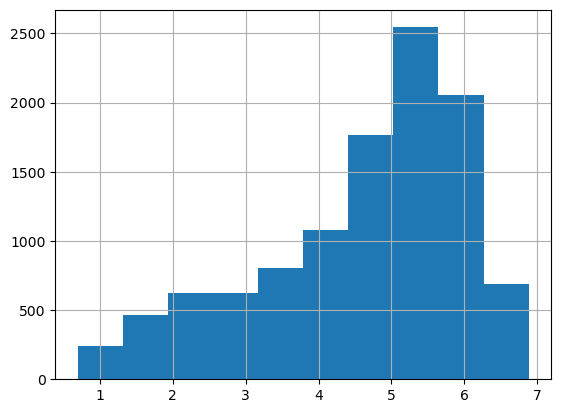

In [26]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [28]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환 
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression() 
lr_reg.fit(X_train, y_train) 
pred= lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm을 이용해 원래 스케일로 변환 
y_test_exp = np.expm1(y_test)

#예측값 역시 로그 변환된 타깃 기반으로 학습 예측됐으므로 다시 expm1로 스케일 변환 
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<AxesSubplot:ylabel='None'>

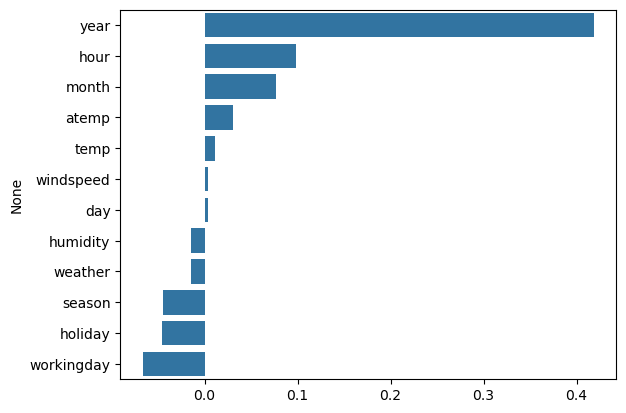

In [29]:
# 회귀계수 확인 및 시각화
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [31]:
#카테고리 피처 원핫인코딩 진행
X_feature_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

In [32]:
X_feature_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
1,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
2,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
3,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
4,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10882,14.76,17.425,57,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10883,13.94,15.910,61,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10884,13.94,17.425,61,6.0032,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False


In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

cat_features = ['year','month','day','hour','holiday','workingday','season','weather']

X_encoded = encoder.fit_transform(X_features[cat_features])

# 인코딩 결과를 새로운 데이터프레임에 추가
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_features))

# 기존 데이터프레임과 합치기
result_df = pd.concat([X_features, encoded_df], axis=1)

# 'Category' 열과 중복되는 열 삭제
result_df = result_df.drop(cat_features, axis=1)

# 결과 확인
print(result_df)

        temp   atemp  humidity  windspeed  year_2011  year_2012  month_1  \
0       9.84  14.395        81     0.0000        1.0        0.0      1.0   
1       9.02  13.635        80     0.0000        1.0        0.0      1.0   
2       9.02  13.635        80     0.0000        1.0        0.0      1.0   
3       9.84  14.395        75     0.0000        1.0        0.0      1.0   
4       9.84  14.395        75     0.0000        1.0        0.0      1.0   
...      ...     ...       ...        ...        ...        ...      ...   
10881  15.58  19.695        50    26.0027        0.0        1.0      0.0   
10882  14.76  17.425        57    15.0013        0.0        1.0      0.0   
10883  13.94  15.910        61    15.0013        0.0        1.0      0.0   
10884  13.94  17.425        61     6.0032        0.0        1.0      0.0   
10885  13.12  16.665        66     8.9981        0.0        1.0      0.0   

       month_2  month_3  month_4  ...  workingday_0  workingday_1  season_1  \
0       

In [38]:
# 원핫인코딩 적용된 피처, Log 적용된 타겟
X_train, X_test, y_train,y_test = train_test_split(X_feature_ohe,y_target_log,test_size=0.3,random_state=0)

# 성능 평가 수치를 반환
def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha= 10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<AxesSubplot:ylabel='None'>

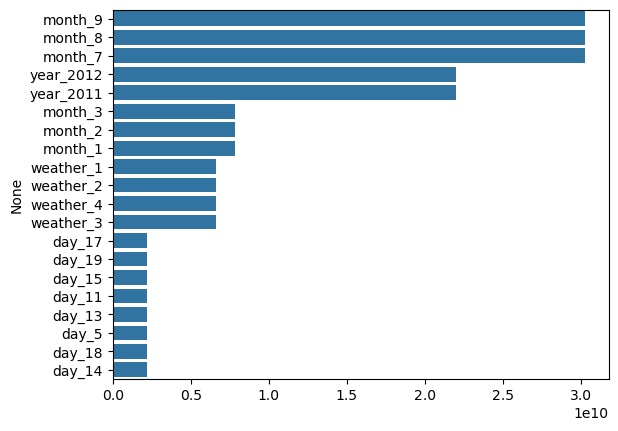

In [39]:
coef = pd.Series(lr_reg.coef_, index=X_feature_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [42]:
# 회귀 트리 활용
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500) 
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500) 
# lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg
            #   , lgbm_reg
              ]:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.423, MAE: 31.183
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.368, MAE: 32.762
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
